<a href="https://colab.research.google.com/github/haoboooo/Temporal-Effect-of-Sentiment-Analysis/blob/main/software_merge_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# install emoji library
!pip install emot

In [36]:
import pandas as pd
import numpy as np
import string

# store models
import pickle
from sklearn.pipeline import Pipeline

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## load software data

In [38]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/software/98_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/software/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/software/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/software/18.csv"

In [39]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(27028, 3)
 1.0    13613
-1.0    11120
 0.0     2295
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,-Great devotional Bible written with easy-to-u...
1,1.0,2006,I love the new king james version of the the l...
2,1.0,2005,I highly recommend this version of the bible f...
3,1.0,2005,This Bible is a great study help. The comment...
4,1.0,2005,Great Bible for study - very informative and t...


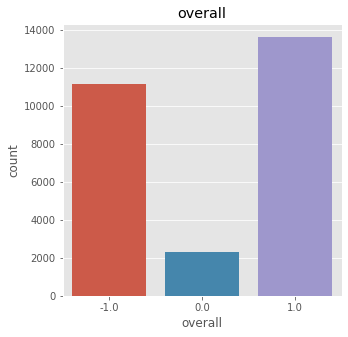

In [40]:
# load data for 1998 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(83773, 3)
 1.0    48362
-1.0    27920
 0.0     7491
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2011,"Strong backgroung, good read, quite up to date..."
1,0.0,2010,If you live on Mars and never heard of the int...
2,1.0,2010,i got this book on amazon and it ended up savi...
3,1.0,2010,I was very happy with this purchase because th...
4,1.0,2010,Recieved in a timely manner- book in great con...


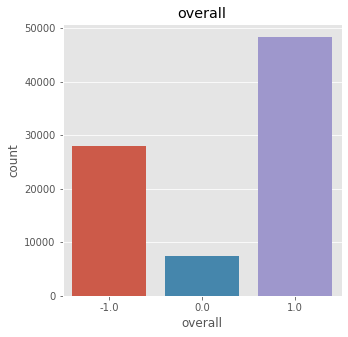

In [41]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(235021, 3)
 1.0    146179
-1.0     69066
 0.0     19776
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2014,The materials arrived early and were in excell...
1,1.0,2014,I am really enjoying this book with the worksh...
2,-1.0,2014,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,0.0,2014,This book was missing pages!!! Important pages...
4,1.0,2013,I have used LearnSmart and can officially say ...


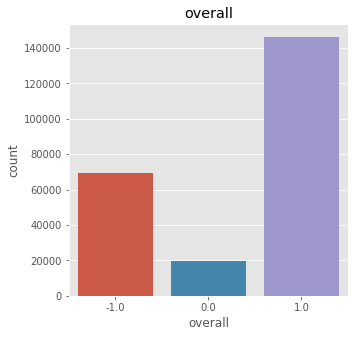

In [42]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(10435, 3)
 1.0    5925
-1.0    3732
 0.0     778
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2018,Product had false key. Fake Microsoft phone n...
1,1.0,2018,the codes worked fine. Im not really a fan of...
2,1.0,2018,This product was good i loved that i was able ...
3,1.0,2018,It is just a must have for your computer what ...
4,1.0,2018,Having access on more than one device helps.


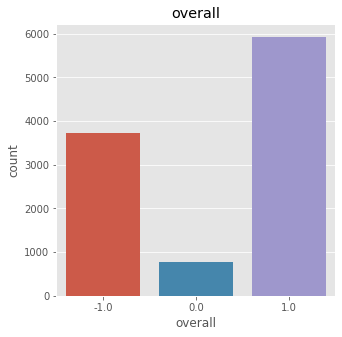

In [43]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

#### Split and Balance for each time period

In [44]:
def split_balance(df,counts):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # compute the index to split 80% for train 20% for test
  posind = int(counts[1]*0.8)
  neuind = int(counts[0]*0.8)
  negind = int(counts[-1]*0.8)

  # split to get train for each class
  pos_train = pos.iloc[:posind,:]
  neu_train = neu.iloc[:neuind,:]
  neg_train = neg.iloc[:negind,:]

  # split to get test for each class
  pos_test = pos.iloc[posind:,:]
  neu_test = neu.iloc[neuind:,:]
  neg_test = neg.iloc[negind:,:]

  # combine train dataset
  df_train = pd.concat([pos_train, neu_train, neg_train],sort=False).sample(frac=1.0)
  df_train_label = df_train.overall

  # combine test dataset
  df_test = pd.concat([pos_test, neu_test, neg_test],sort=False).sample(frac=1.0)
  df_test_label = df_test.overall

  return df_train,df_train_label,df_test,df_test_label

In [45]:
# split train and test data for 1998 - 2006
df1_train,df1_train_label,df1_test,df1_test_label = split_balance(df1,counts1)

# get train and test text
df1_train_data = df1_train.reviewText
df1_test_data = df1_test.reviewText

# split train and test data for 2007 - 2012
df2_train,df2_train_label,df2_test,df2_test_label = split_balance(df2,counts2)

# get train and test text
df2_train_data = df2_train.reviewText
df2_test_data = df2_test.reviewText

# split train and test data for 2013 - 2017
df3_train,df3_train_label,df3_test,df3_test_label = split_balance(df3,counts3)

# get train and test text
df3_train_data = df3_train.reviewText
df3_test_data = df3_test.reviewText

# split train and test data for 2018
df4_train,df4_train_label,df4_test,df4_test_label = split_balance(df4,counts4)

# get train and test text
df4_train_data = df4_train.reviewText
df4_test_data = df4_test.reviewText

#### Merge 20% of each time period

In [46]:
# get 20% of each train to merge a train data
size1,size2,size3,size4 = len(df1_train_data),len(df2_train_data),len(df3_train_data),len(df4_train_data)
print(size1,size2,size3,size4)
ind1,ind2,ind3,ind4 = int(size1*0.2),int(size2*0.2),int(size3*0.2),int(size4*0.2)
train1,label1 = df1_train_data.iloc[:ind1],df1_train_label.iloc[:ind1]
train2,label2 = df2_train_data.iloc[:ind2],df2_train_label.iloc[:ind2]
train3,label3 = df3_train_data.iloc[:ind3],df3_train_label.iloc[:ind3]
train4,label4 = df4_train_data.iloc[:ind4],df4_train_label.iloc[:ind4]

merge_train_data = pd.concat([train1, train2, train3, train4],sort=False)
merge_train_label = pd.concat([label1,label2,label3,label4],sort=False)
merge_train_data.shape,merge_train_label.shape

21622 67017 188015 8347


((56999,), (56999,))

## Text Preprocessing

In [47]:
# Defining my NLTK stop words and my user-defined stop words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [48]:
def processtext(txt):
  # convert tweet to lower case
  txt = txt.lower()
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  # remove whitespace
  txt = txt.strip()

  # tokenization with nltk
  data = word_tokenize(txt)
  # stemming with nltk
  porter = PorterStemmer()
  stem_data = [porter.stem(word) for word in data]
  return stem_data

## Text Representation

### Learn on 2018;Estimate on 2018

In [18]:
# min
# TFIDF, unigrams and trigrams
vect = TfidfVectorizer(tokenizer=processtext, sublinear_tf=True, norm='l2', ngram_range=(1,3))
# fit on previous 2018 data
vect.fit_transform(df4.reviewText)

# transform testing and training datasets to vectors
df4_train_vect = vect.transform(df4_train_data)
df4_test_vect = vect.transform(df4_test_data)

### Learn on merge data;Estimate on 98-06,07-12,13-17,18

In [49]:
tfidf_vec = TfidfVectorizer(tokenizer=processtext, sublinear_tf=True, norm='l2', ngram_range=(1,3))
tfidf_vec.fit_transform(merge_train_data)

test_vect1 = tfidf_vec.transform(df1_test_data)
test_vect2 = tfidf_vec.transform(df2_test_data)
test_vect3 = tfidf_vec.transform(df3_test_data)
test_vect4 = tfidf_vec.transform(df4_test_data)

In [51]:
merged_data = tfidf_vec.transform(merge_train_data)

## Classifiers

### Learn on 2018;Estimate on 2018

#### Linear Support Vector

In [19]:
svc18 = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
svc18.fit(df4_train_vect, df4_train_label)
ysvm_pred18 = svc18.predict(df4_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ysvm_pred18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ysvm_pred18, average='micro') * 100))

Accuracy: 84.48%

F1 Score: 84.48


#### Logistic Regression

In [20]:
lr18=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
lr18.fit(df4_train_vect, df4_train_label)
ylog_pred18 = lr18.predict(df4_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ylog_pred18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ylog_pred18, average='micro') * 100))

Accuracy: 84.05%

F1 Score: 84.05


#### Naive Bayes

In [21]:
nb18 = MultinomialNB(alpha=0.1,fit_prior=True)

nb18.fit(df4_train_vect, df4_train_label)
ynb_pred18 = nb18.predict(df4_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ynb_pred18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ynb_pred18, average='micro') * 100))

Accuracy: 83.43%

F1 Score: 83.43


#### Random Forest

In [22]:
# estimated 5hrs
rf18 = RandomForestClassifier(n_estimators=100,criterion='entropy',n_jobs=-1)
rf18.fit(df4_train_vect, df4_train_label)
yrf_pred18 = rf18.predict(df4_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, yrf_pred18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, yrf_pred18, average='micro') * 100))

Accuracy: 80.27%

F1 Score: 80.27


### Learn on Merged data;Estimate on each time period

#### Linear Support Vector

In [52]:
svc = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
svc.fit(merged_data, merge_train_label)

LinearSVC()

In [55]:
ysvm_pred1 = svc.predict(test_vect1)
print("For 1998-2006\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, ysvm_pred1) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, ysvm_pred1, average='micro') * 100))

ysvm_pred2 = svc.predict(test_vect2)
print("For 2007-2012\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, ysvm_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, ysvm_pred2, average='micro') * 100))

ysvm_pred3 = svc.predict(test_vect3)
print("For 2013-2017\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, ysvm_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, ysvm_pred3, average='micro') * 100))

ysvm_pred4 = svc.predict(test_vect4)
print("For 2018\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ysvm_pred4) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ysvm_pred4, average='micro') * 100))

For 1998-2006

Accuracy: 83.67%

F1 Score: 83.67
For 2007-2012

Accuracy: 84.38%

F1 Score: 84.38
For 2013-2017

Accuracy: 85.74%

F1 Score: 85.74
For 2018

Accuracy: 86.02%

F1 Score: 86.02


#### Logistic Regression

In [54]:
lr=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
lr.fit(merged_data, merge_train_label)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=10.0, max_iter=200)

In [56]:
ylog_pred1 = lr.predict(test_vect1)
print("For 1998-2006\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, ylog_pred1) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, ylog_pred1, average='micro') * 100))

ylog_pred2 = lr.predict(test_vect2)
print("For 2007-2012\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, ylog_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, ylog_pred2, average='micro') * 100))

ylog_pred3 = lr.predict(test_vect3)
print("For 2013-2017\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, ylog_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, ylog_pred3, average='micro') * 100))

ylog_pred4 = lr.predict(test_vect4)
print("For 2018\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ylog_pred4) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ylog_pred4, average='micro') * 100))

For 1998-2006

Accuracy: 83.24%

F1 Score: 83.24
For 2007-2012

Accuracy: 84.20%

F1 Score: 84.20
For 2013-2017

Accuracy: 85.45%

F1 Score: 85.45
For 2018

Accuracy: 85.54%

F1 Score: 85.54


#### Naive Bayes

In [57]:
nb = MultinomialNB(alpha=0.1,fit_prior=True)
nb.fit(merged_data, merge_train_label)

MultinomialNB(alpha=0.1)

In [58]:
ynb_pred1 = nb.predict(test_vect1)
print("For 1998-2006\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, ynb_pred1) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, ynb_pred1, average='micro') * 100))

ynb_pred2 = nb.predict(test_vect2)
print("For 2007-2012\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, ynb_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, ynb_pred2, average='micro') * 100))

ynb_pred3 = nb.predict(test_vect3)
print("For 2007-2012\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, ynb_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, ynb_pred3, average='micro') * 100))

ynb_pred4 = nb.predict(test_vect4)
print("For 2018\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ynb_pred4) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ynb_pred4, average='micro') * 100))

For 1998-2006

Accuracy: 78.19%

F1 Score: 78.19
For 2007-2012

Accuracy: 80.39%

F1 Score: 80.39
For 2007-2012

Accuracy: 82.51%

F1 Score: 82.51
For 2018

Accuracy: 83.43%

F1 Score: 83.43


#### Random Forest

In [59]:
# estimated 5hrs
rf = RandomForestClassifier(n_estimators=100,criterion='entropy',n_jobs=-1)
rf.fit(merged_data, merge_train_label)

RandomForestClassifier(criterion='entropy', n_jobs=-1)

In [60]:
yrf_pred1 = rf.predict(test_vect1)
print("For 1998-2006\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, yrf_pred1) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, yrf_pred1, average='micro') * 100))

yrf_pred2 = rf.predict(test_vect2)
print("For 2007-2012\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, yrf_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, yrf_pred2, average='micro') * 100))

yrf_pred3 = rf.predict(test_vect3)
print("For 2013-2017\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, yrf_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, yrf_pred3, average='micro') * 100))

yrf_pred4 = rf.predict(test_vect4)
print("For 2013-2017\n")
print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, yrf_pred4) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, yrf_pred4, average='micro') * 100))

For 1998-2006

Accuracy: 74.32%

F1 Score: 74.32
For 2007-2012

Accuracy: 76.54%

F1 Score: 76.54
For 2013-2017

Accuracy: 78.38%

F1 Score: 78.38
For 2013-2017

Accuracy: 77.97%

F1 Score: 77.97


## Store models

In [24]:
def store_model(i,vect,svm,lr,nb,rf):
  pipe1 = Pipeline([
    ('tfidf', vect),
    ('svm', svm),
    ])
  pipe2 = Pipeline([
    ('tfidf', vect),
    ('lr', lr),
    ])
  pipe3 = Pipeline([
    ('tfidf', vect),
    ('nb', nb),
    ])
  pipe4 = Pipeline([
    ('tfidf', vect),
    ('rf', rf),
    ])
  if i == 18:
    dir = '18'
  else:
    dir = 'merge'
  filename1 = './drive/MyDrive/Colab Notebooks/CL/software/'+dir+'/svm.pickle'
  filename2 = './drive/MyDrive/Colab Notebooks/CL/software/'+dir+'/lr.pickle'
  filename3 = './drive/MyDrive/Colab Notebooks/CL/software/'+dir+'/nb.pickle'
  filename4 = './drive/MyDrive/Colab Notebooks/CL/software/'+dir+'/rf.pickle'
  pickle.dump(pipe1, open(filename1, 'wb'))
  pickle.dump(pipe2, open(filename2, 'wb'))
  pickle.dump(pipe3, open(filename3, 'wb'))
  pickle.dump(pipe4, open(filename4, 'wb'))  

In [25]:
store_model(18,vect,svc18,lr18,nb18,rf18)

In [61]:
store_model(0,tfidf_vec,svc,lr,nb,rf)